In [29]:
import numpy as np
from math import sqrt
from pprint import pprint
from sklearn import datasets
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [30]:
# Cargar y explorar los datos
datos = datasets.fetch_california_housing()
pprint(datos)
print(np.shape(datos.data))

{'DESCR': '.. _california_housing_dataset:\n'
          '\n'
          'California Housing dataset\n'
          '--------------------------\n'
          '\n'
          '**Data Set Characteristics:**\n'
          '\n'
          '    :Number of Instances: 20640\n'
          '\n'
          '    :Number of Attributes: 8 numeric, predictive attributes and the '
          'target\n'
          '\n'
          '    :Attribute Information:\n'
          '        - MedInc        median income in block group\n'
          '        - HouseAge      median house age in block group\n'
          '        - AveRooms      average number of rooms per household\n'
          '        - AveBedrms     average number of bedrooms per household\n'
          '        - Population    block group population\n'
          '        - AveOccup      average number of household members\n'
          '        - Latitude      block group latitude\n'
          '        - Longitude     block group longitude\n'
          '\n'
  

In [31]:
# Extraer la matriz de datos "X" y la variable target "y"
X = datos.data
y = datos.target

print(X)
print()
print(y)

[[   8.3252       41.            6.98412698 ...    2.55555556
    37.88       -122.23      ]
 [   8.3014       21.            6.23813708 ...    2.10984183
    37.86       -122.22      ]
 [   7.2574       52.            8.28813559 ...    2.80225989
    37.85       -122.24      ]
 ...
 [   1.7          17.            5.20554273 ...    2.3256351
    39.43       -121.22      ]
 [   1.8672       18.            5.32951289 ...    2.12320917
    39.43       -121.32      ]
 [   2.3886       16.            5.25471698 ...    2.61698113
    39.37       -121.24      ]]

[4.526 3.585 3.521 ... 0.923 0.847 0.894]


In [32]:
# Partición EXTERNA: hold-out split 80% train - 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

valores_test, ocur_test = np.unique(y_test, return_counts=True)
print('Test ->      ', 'clases:', valores_test, ' ocurrencias: ', ocur_test)

valores_train, ocur_train = np.unique(y_train, return_counts=True)
print('Training -> ', ' clases:', valores_train, '  ocurrencias:', ocur_train)

Test ->       clases: [0.14999 0.175   0.225   ... 4.956   5.      5.00001]  ocurrencias:  [  1   1   1 ...   1   5 179]
Training ->   clases: [0.14999 0.225   0.25    ... 4.991   5.      5.00001]   ocurrencias: [  3   3   1 ...   1  22 786]


In [33]:
# Estandarización de los datos de entrenamiento
standardizer = StandardScaler()
X_train = standardizer.fit_transform(X_train)
X_test = standardizer.transform(X_test)

In [34]:
# Métricas de evaluación.
metricas = {
  'MAE': 'neg_mean_absolute_error',
  'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(mean_squared_error(y, y_pred)),
                      greater_is_better=False),
  'MAPE': make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False)}

In [35]:
# Definimos un algoritmo SVM de regresión
svr = SVR(C=10, gamma='scale', kernel='rbf')

In [36]:
# Validación y evaluación del modelo.
# en "cv = KFold(n_splits=5)" se hace un cross-validation INTERNO!! 
results = cross_validate(svr, X_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring = metricas)

In [37]:
# Presentación de los resultados de la evaluación.
pprint(results)

{'fit_time': array([5.61159325, 5.3135407 , 5.14977717, 5.32317686, 5.42992353]),
 'score_time': array([1.49748945, 1.53135943, 1.50546885, 1.49113059, 1.49067402]),
 'test_MAE': array([-0.38641873, -0.37391886, -0.36490069, -0.38307737, -0.37652549]),
 'test_MAPE': array([-20.528408  , -20.15907877, -19.81825675, -20.55875975,
       -19.61675511]),
 'test_RMSE': array([-0.5759555 , -0.5705538 , -0.54688658, -0.58892629, -0.55996347])}


In [38]:
# Una vez hemos optimizado los hiperparámetros en el conjunto de validación, entrenamos un nuevo modelo que contenga
# todos los datos de entrenamiento (es decir, train + validation) para evaluar el test
model = SVR(C=10, gamma='scale', kernel='rbf')
model = model.fit(X_train, y_train)

In [39]:
# Extraemos el error absoluto promedio (MAE) del conjunto de test
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_pred, y_test)
print('Test results (MAE): ', mae)

Test results (MAE):  0.37744436929218994


In [40]:
# También podemos extraer las predicciones para cuánto difieren los valores predichos de los reales
print('Predicciones:   ', np.round(y_pred[:10], 1))
print('Valores reales: ', y_test[:10])

Predicciones:    [0.5 1.4 4.3 2.4 2.8 1.7 2.6 1.7 2.3 4.7]
Valores reales:  [0.477   0.458   5.00001 2.186   2.78    1.587   1.982   1.575   3.4
 4.466  ]


In [41]:
# Grafica de realidad -vs- prediccion.
def report_regression_graphics(y_true, y_pred):
    fig, ax = plt.subplots(2, 1)

    # Plot linear fit
    ax[0].scatter(y_true, y_pred)
    ax[0].set_ylabel('y_pred')
    ax[0].set_title('Regression line')
    ax[0].grid()
    # overlay the regression line
    z = np.polyfit(np.float64(y_true), y_pred, 1)
    p = np.poly1d(z)
    ax[0].plot(y_true, p(y_true), color='magenta')

    # Plot bisectriz
    ax[1].scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax[1].set_xlabel('y_true')
    ax[1].set_ylabel('y_pred')
    ax[1].set_title('Bisector')
    ax[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax[1].grid()

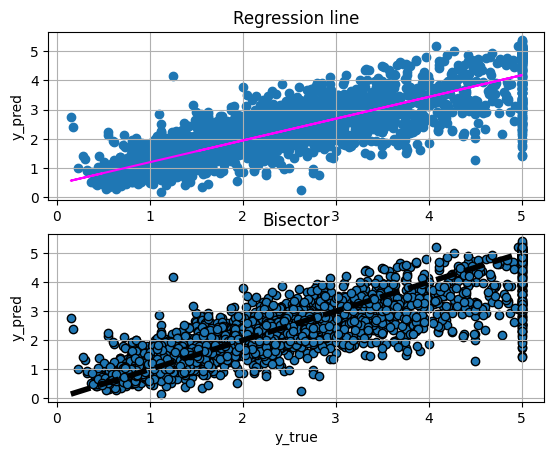

In [43]:
report_regression_graphics(y_test, y_pred)